# Import packages

In [573]:
import json
import pandas as pd
import numpy as np
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Define common use functions for data parsing

In [232]:
def flatten_dict(nested_dict, prefix = ''):
    """Flatten bested dictionary with custom prefix"""
    flat_dict = {}
    for key, value in nested_dict.items():
        if isinstance(value, dict):
            flat_dict.update(flatten_dict(value, f"{prefix}{key}_"))
        else:
            flat_dict[f"{prefix}{key}"] = value
    return flat_dict

def parse_nested_json_flatten(file_path):
    """Read and Faltten JSON lines"""
    flat_records = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip().startswith('{'):
                record = json.loads(line.strip())
                flat_records.append(flatten_dict(record))

    return pd.DataFrame(flat_records)

def process_receipt_items(df):
    """Process rewardsReceiptItemList from DataFrame into flattened DataFrame"""
    items = []
    for _, row in df.iterrows():
        receipt_items = row.get('rewardsReceiptItemList')
        if not isinstance(receipt_items, list):
            continue
        receipt_id = row['receiptId']
        for item in receipt_items:
            if isinstance(item, dict):
                flat_item = flatten_dict(item)
                flat_item['receiptId'] = receipt_id
                items.append(flat_item)
    return pd.DataFrame(items) if items else pd.DataFrame() 

# Process brands data from JSON into Pandas DataFrame

In [136]:
# Read JSON into brands dataframe
brands_df = parse_nested_json_flatten('brands.json')
# Align column names and order with our data model for easy readability
brands_df.columns = brands_df.columns.str.replace(r'[_$]', '', regex = True)
brands_df = brands_df.rename(columns = {'idoid': 'brandId', 'cpgidoid': 'cpgOid', 'cpgref': 'cpgRef', 'name' : 'brandName'})
brands_df = brands_df[['brandId'] + sorted([col for col in brands_df.columns if col != 'brandId'])]

In [234]:
brands_df.head()

,brandId,barcode,brandCode,brandName,category,categoryCode,cpgOid,cpgRef,topBrand
0,601ac115be37ce2ead437551,511111019862,NaN,test brand @1612366101024,Baking,BAKING,601ac114be37ce2ead437550,Cogs,False
1,601c5460be37ce2ead43755f,511111519928,STARBUCKS,Starbucks,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,False
2,601ac142be37ce2ead43755d,511111819905,TEST BRANDCODE @1612366146176,test brand @1612366146176,Baking,BAKING,601ac142be37ce2ead437559,Cogs,False
3,601ac142be37ce2ead43755a,511111519874,TEST BRANDCODE @1612366146051,test brand @1612366146051,Baking,BAKING,601ac142be37ce2ead437559,Cogs,False
4,601ac142be37ce2ead43755e,511111319917,TEST BRANDCODE @1612366146827,test brand @1612366146827,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,False


In [150]:
# Read JSON into user dataframe
users_df = parse_nested_json_flatten('users.json')
users_df.columns = users_df.columns.str.replace(r'[_$]', '', regex = True)
users_df = users_df.rename(columns = {'idoid': 'userId', 'createdDatedate': 'createdDate', 'lastLogindate': 'lastLogin'})
users_df = users_df[['userId'] + sorted([col for col in users_df.columns if col != 'userId'])]

In [236]:
users_df.head()

,userId,active,createdDate,lastLoginDate,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,1609687530554,1.609688e+12,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,1609687444800,1.609688e+12,consumer,Email,WI


In [563]:
# Read JSON into receipts dataframe
receipts_df = parse_nested_json_flatten('receipts.json')
receipts_df.columns = receipts_df.columns.str.replace(r'[_$]', '', regex = True)
receipts_df = receipts_df.rename(columns = {'idoid': 'receiptId', 'createDatedate': 'createDate', 'dateScanneddate': 'dateScanned', 'finishedDatedate': 'finishedDate', 'modifyDatedate': 'modifyDate', 'purchaseDatedate':'purchaseDate','pointsAwardedDatedate':'pointsAwardedDate'})
receipts_df = receipts_df[['receiptId'] + sorted([col for col in receipts_df.columns if col != 'receiptId'])]

# Note that we don't need rewardsReceiptItemList inside this table since it will have its own table based on my data model design.

In [565]:
receipts_df.head()

,receiptId,bonusPointsEarned,bonusPointsEarnedReason,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,pointsEarned,purchaseDate,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId
0,5ff1e1eb0a720f0523000575,500.0,"Receipt number 2 completed, bonus point schedu...",1609687531000,1609687531000,1.609688e+12,1609687536000,1.609688e+12,500.0,1.609632e+12,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.00,5ff1e1eacfcf6c399c274ae6
1,5ff1e1bb0a720f052300056b,150.0,"Receipt number 5 completed, bonus point schedu...",1609687483000,1609687483000,1.609687e+12,1609687488000,1.609687e+12,150.0,1.609601e+12,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.00,5ff1e194b6a9d73a3a9f1052
2,5ff1e1f10a720f052300057a,5.0,All-receipts receipt bonus,1609687537000,1609687537000,NaN,1609687542000,NaN,5,1.609632e+12,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,5ff1e1f1cfcf6c399c274b0b
3,5ff1e1ee0a7214ada100056f,5.0,All-receipts receipt bonus,1609687534000,1609687534000,1.609688e+12,1609687539000,1.609688e+12,5.0,1.609632e+12,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.00,5ff1e1eacfcf6c399c274ae6
4,5ff1e1d20a7214ada1000561,5.0,All-receipts receipt bonus,1609687506000,1609687506000,1.609688e+12,1609687511000,1.609688e+12,5.0,1.609601e+12,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.00,5ff1e194b6a9d73a3a9f1052


In [188]:
# Read reward item column into its own dataframe
items_df = process_receipt_items(receipts_df)
items_df = items_df[['receiptId'] + ['barcode'] + sorted([col for col in items_df.columns if col not in ['receiptId','barcode']])]

In [240]:
items_df.head()

,receiptId,barcode,brandCode,competitiveProduct,competitorRewardsGroup,deleted,description,discountedItemPrice,finalPrice,itemNumber,itemPrice,metabriteCampaignId,needsFetchReview,needsFetchReviewReason,originalFinalPrice,originalMetaBriteBarcode,originalMetaBriteDescription,originalMetaBriteItemPrice,originalMetaBriteQuantityPurchased,originalReceiptItemText,partnerItemId,pointsEarned,pointsNotAwardedReason,pointsPayerId,preventTargetGapPoints,priceAfterCoupon,quantityPurchased,rewardsGroup,rewardsProductPartnerId,targetPrice,userFlaggedBarcode,userFlaggedDescription,userFlaggedNewItem,userFlaggedPrice,userFlaggedQuantity
0,5ff1e1eb0a720f0523000575,4011,NaN,NaN,NaN,NaN,ITEM NOT FOUND,NaN,26.00,NaN,26.00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,True,NaN,5.0,NaN,NaN,NaN,4011,NaN,True,26.00,5.0
1,5ff1e1bb0a720f052300056b,4011,NaN,NaN,NaN,NaN,ITEM NOT FOUND,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,028400642255,NaN,NaN,NaN,NaN,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,NaN,10.00,NaN,10.00,NaN,True,USER_FLAGGED,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,Action not allowed for user and CPG,5332f5fbe4b03c9a25efd0ba,True,NaN,1.0,DORITOS SPICY SWEET CHILI SINGLE SERVE,5332f5fbe4b03c9a25efd0ba,NaN,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,True,10.00,1.0
3,5ff1e1f10a720f052300057a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,4011,NaN,True,26.00,3.0
4,5ff1e1ee0a7214ada100056f,4011,NaN,NaN,NaN,NaN,ITEM NOT FOUND,NaN,28.00,NaN,28.00,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,True,NaN,4.0,NaN,NaN,NaN,4011,NaN,True,28.00,4.0


# Question 1: Review Existing Unstructured Data and Diagram a New Structured Relational Data Model
     
       

See **File: data_model.pdf**  

I skimmed through the JSON files and noticed that more columns might be needed compared to the provided schema.
To avoid manually checking each column, I processed the data in Python first, converting it into a more readable format
to efficiently extract columns and their types.  


# Question2: Write queries that directly answer predetermined questions from a business stakeholder

## What are the top 5 brands by receipts scanned for most recent month?

### Query Explanation  

To answer this question, assuming there is no data quality issue, I need the **dataScanned** from the **receipts** table and **brandcode** from the **items** table.  
- **dataScanned** represents the date when the user scanned their receipt, which usually happens after the purchase date.  
- **brandcode** is a unique identifier for each brand.  

Depending on the request, stakeholders might want **brandName** instead of **brandcode**.
In that case, I would need to join the **brand** table with **items** using the **barcode**.
However, for this scenario, I will assume that retrieving **brandcode** is sufficient.  

In [211]:
query = """
WITH recent_month AS (
  SELECT DATE_FORMAT(DATE_ADD(CURDATE(), INTERVAL -1 MONTH), '%Y-%m-01') AS past_month_first,
         DATE_FORMAT(CURDATE(), '%Y-%m-01') AS current_month_first
)
SELECT i.brandCode, COUNT(DISTINCT(i.receiptId)) AS receipt_count
FROM items i
JOIN receipts r ON r.receiptId = i.receiptId
WHERE r.dataScanned >= (SELECT past_month_first FROM recent_month)
AND r.dataScanned < (SELECT current_month_first FROM recent_month)
GROUP BY i.brandCode
ORDER BY receipt_count DESC
LIMIT 5;
"""

## When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

### Query Explanation

To answer this question, I will communicate with stakeholders to define what "average spend" means. For this exercise, the definition of **Average Spend** is as follows:

- Use the **totalSpent** field from the **receipts** table.
- Calculate the simple arithmetic mean: **(total amount spent) / (number of receipts)**.
- Exclude **NULL** values to ensure accurate calculations.
- Apply constraints to include only **active customers**, excluding **fetch-staff** and other test users.


In [228]:
query = """
    SELECT 
        r.rewardsReceiptStatus,
        ROUND(AVG(r.totalSpent), 2) as average_spend
    FROM receipts r
    JOIN users u ON r.userId = u.userId
    WHERE r.rewardsReceiptStatus IN ('Accepted', 'Rejected')
        AND r.totalSpent IS NOT NULL
        AND u.active = 1 -- True
        AND u.role = 'customer'
    GROUP BY r.rewardsReceiptStatus
    ORDER BY average_spend DESC;
"""

# Third: Evaluate Data Quality Issues in the Data Provided

Before using SQL tables to answer predetermined questions, it is crucial to ensure data quality across all datasets. Poor data quality can lead to inaccurate insights, flawed business decisions, and unreliable reporting. Each table should be checked for duplicates, NULL values, inconsistent formats, and missing or outdated records before performing any analysis.

If there are data quality issues, they can create significant problems, especially when joining tables:

- **Duplicate Records**: If a table contains duplicate rows, joins can produce inflated results, leading to incorrect aggregations and misleading conclusions.
- **NULL or Missing Values**: Missing foreign key values can result in dropped records during INNER JOINs, reducing the completeness of the dataset.
- **Inconsistent Data Types or Formats**: Mismatched formats (e.g., different date formats or string inconsistencies) can prevent joins from working correctly, causing data loss or errors.

In [3]:
"""Functions for data quality check"""
def convert_timestamp(df, cols):
    """converts Unix timestamp (milliseconds) to a human-readable datetime format. """
    for col in cols:
        df[col] = df[col].apply(lambda x: pd.to_datetime(x, unit='ms') if pd.notna(x) else x)
    return df

def check_duplicates(df):
    """Check for duplicate rows"""
    duplicates = df[df.duplicated()]
    
    if not duplicates.empty:
        print(f"There are {duplicates.shape[0]} duplicate rows.")
        return duplicates
    else:
        print("No duplicates found")
        return pd.DataFrame()

def print_null_counts(df):
    """Count the number of NaN values per column and print it"""
    null_counts = df.isna().sum()
    
    print("Number of null values in each column:")
    for col, count in null_counts.items():
        print(f"{col}: {count}")
        

"""Functions for plotting"""
def plot_columns_with_max_greater_than_3std(df):
    """
    Plots histograms for columns of type float or int where the maximum value is greater than 
    3 times the standard deviation.
    """
    # Select only float and int columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])
    std_devs = numeric_df.std()
    max_values = numeric_df.max()

    # Identify columns where the maximum value is greater than 3 std devs
    columns_to_plot = max_values[max_values > 3 * std_devs].index

    if len(columns_to_plot) == 0:
        print("No columns meet the condition (max > 3 std).")
        return

    # Plot histograms for those columns
    plt.figure(figsize=(12, 8))

    for i, column in enumerate(columns_to_plot, 1):
        filtered_data = numeric_df[column][numeric_df[column] != 0]
        
        # Only plot if there's data remaining after excluding zeros
        if len(filtered_data) > 0:
            plt.subplot(2, len(columns_to_plot) // 2 + 1, i)
            sns.histplot(filtered_data, kde=True, bins=100) 
            plt.title(f'Distribution of {column}')

    plt.tight_layout()
    plt.show()

## Check tables one by one:

## check users_df 

In [268]:
# The previous users_df has an unreable timestamp format, so let's conver it correctly
users_df =convert_timestamp(users_df,  ['createdDate', 'lastLoginDate'])

In [296]:
users_df.head()

,userId,active,createdDate,lastLoginDate,role,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


In [298]:
user_duplicates_df = check_duplicates(users_df)

There are 283 duplicate rows.


In [310]:
user_duplicates_df.head()

,userId,active,createdDate,lastLoginDate,role,signUpSource,state
1,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
5,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI
8,5ff1e194b6a9d73a3a9f1052,True,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,consumer,Email,WI


These exact duplicates should be deleted to maintain data integrity. Additionally, we need to:

- Understand why duplicates exist in the data.
- Investigate the upstream processes to identify what caused the duplication.

In [346]:
print_null_counts(users_df[users_df['role'] == 'fetch-staff'])

Number of null values in each column:
userId: 0
active: 0
createdDate: 0
lastLoginDate: 0
role: 0
signUpSource: 39
state: 41


In [348]:
print_null_counts(users_df[users_df['role'] == 'consumer'])

Number of null values in each column:
userId: 0
active: 0
createdDate: 0
lastLoginDate: 62
role: 0
signUpSource: 9
state: 15


These **NULL** values make sense to me for several reasons:

- A **user** or **staff** member can register an account without logging in, which would result in missing values for some fields.
- The process might stop after account creation or could be incomplete, depending on how you define the **created date**. If the process isn't fully completed, certain fields might be left as NULL.
- **Signup source** and **state** can also be NULL if the app's privacy settings are disabled, which prevents the collection of the user's location and signup source.

We should consider these factors when interpreting the NULL values and ensure we account for any potential gaps in the data collection process.

## check brands_df

In [488]:
# I assume the test brand is still onboarding so we don't need to look at them
brands_filtered_df = brands_df[~brands_df['brandName'].str.startswith('test')]

In [490]:
brands_filtered_df.head()

,brandId,barcode,brandCode,brandName,category,categoryCode,cpgOid,cpgRef,topBrand
1,601c5460be37ce2ead43755f,511111519928,STARBUCKS,Starbucks,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,False
7,5cdad0f5166eb33eb7ce0faa,511111104810,J.L. KRAFT,J.L. Kraft,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Cogs,NaN
8,5ab15636e4b0be0a89bb0b07,511111504412,CAMPBELLS HOME STYLE,Campbell's Home Style,Canned Goods & Soups,NaN,5a734034e4b0d58f376be874,Cogs,False
11,57c08106e4b0718ff5fcb02c,511111102540,NaN,MorningStar,NaN,NaN,5332f5f2e4b03c9a25efd0aa,Cpgs,NaN
12,588ba07be4b02187f85cdadd,511111201076,CALUMET,Calumet,Baking,NaN,559c2234e4b06aca36af13c6,Cogs,False


In [492]:
brands_duplicates_df = check_duplicates(brands_filtered_df)

No duplicates found


In [494]:
print_null_counts(brands_filtered_df)

Number of null values in each column:
brandId: 0
barcode: 0
brandCode: 163
brandName: 0
category: 155
categoryCode: 649
cpgOid: 0
cpgRef: 0
topBrand: 407


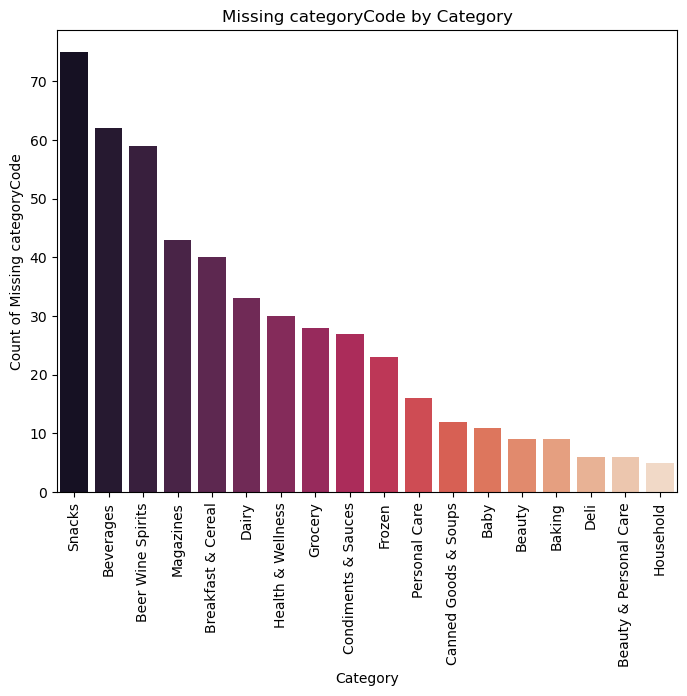

In [496]:
missing_categoryCode_by_category = brands_filtered_df[brands_filtered_df['categoryCode'].isnull()]['category'].value_counts()

# Plot the missing data distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=missing_categoryCode_by_category.index, y=missing_categoryCode_by_category.values, palette='rocket')
plt.title('Missing categoryCode by Category')
plt.xlabel('Category')
plt.ylabel('Count of Missing categoryCode')
plt.xticks(rotation=90)
plt.show()

In [523]:
# This prints out existing number of mapping between category and categoryCode 
for each in brands_filtered_df['category'].unique().tolist():
    temp_df =brands_filtered_df[(brands_filtered_df['category'] == each) & (~brands_filtered_df['categoryCode'].isnull())]
    print(each, temp_df.shape[0])

Beverages 1
Condiments & Sauces 0
Canned Goods & Soups 0
nan 0
Baking 2
Magazines 1
Breakfast & Cereal 0
Beer Wine Spirits 31
Health & Wellness 14
Beauty 0
Baby 7
Frozen 1
Grocery 11
Snacks 0
Household 0
Personal Care 4
Dairy 0
Cleaning & Home Improvement 6
Deli 0
Beauty & Personal Care 0
Bread & Bakery 5
Outdoor 1
Dairy & Refrigerated 5


It's suprising to see we have exisiting mapping for most category but the data records were still missing based on the bar chart. 

### Key Points:

1. **Excluding Placeholder Entries**: Entries such as `"Test Brand"` should be flagged or excluded from the dataset to avoid misleading conclusions. These entries are often used for testing or are incomplete.
  
2. **Improving Taxonomy Mapping**: The relationship between `categoryCode`, `categoryName`, and `brandName` should be clarified and made more consistent to ensure accurate data classification. Snacks category doesn't have any mapping and we should create one.

3. **Use of Existing Mappings**: Since we've identified a mapping for the `categoryCode` of Beverages, it is possible to use this mapping to fill in missing `categoryCode` entries for the entire Beverages if categoryCode only depends on category. The 60 missing rows shows inconsistency on how we create this label.




## check receipts_df

In [581]:
# convert datatype 
receipts_df =convert_timestamp(receipts_df,  ['createDate',	'dateScanned', 'finishedDate',	'modifyDate', 'pointsAwardedDate',	'purchaseDate'])
receipts_df['totalSpent'] = receipts_df['totalSpent'].astype(np.float64)
receipts_df['pointsEarned'] = receipts_df['pointsEarned'].astype(np.float64)

In [583]:
receipts_df.dtypes

receiptId                          object
bonusPointsEarned                 float64
bonusPointsEarnedReason            object
createDate                 datetime64[ns]
dateScanned                datetime64[ns]
finishedDate               datetime64[ns]
modifyDate                 datetime64[ns]
pointsAwardedDate          datetime64[ns]
pointsEarned                      float64
purchaseDate               datetime64[ns]
purchasedItemCount                float64
rewardsReceiptItemList             object
rewardsReceiptStatus               object
totalSpent                        float64
userId                             object
dtype: object

In [585]:
# don't need it here
del receipts_df['rewardsReceiptItemList']

In [587]:
receipts_duplicates_df = check_duplicates(receipts_df)

No duplicates found


In [589]:
receipts_df.shape

(1119, 14)

In [591]:
print_null_counts(receipts_df)

Number of null values in each column:
receiptId: 0
bonusPointsEarned: 575
bonusPointsEarnedReason: 575
createDate: 0
dateScanned: 0
finishedDate: 551
modifyDate: 0
pointsAwardedDate: 582
pointsEarned: 510
purchaseDate: 448
purchasedItemCount: 484
rewardsReceiptStatus: 0
totalSpent: 435
userId: 0


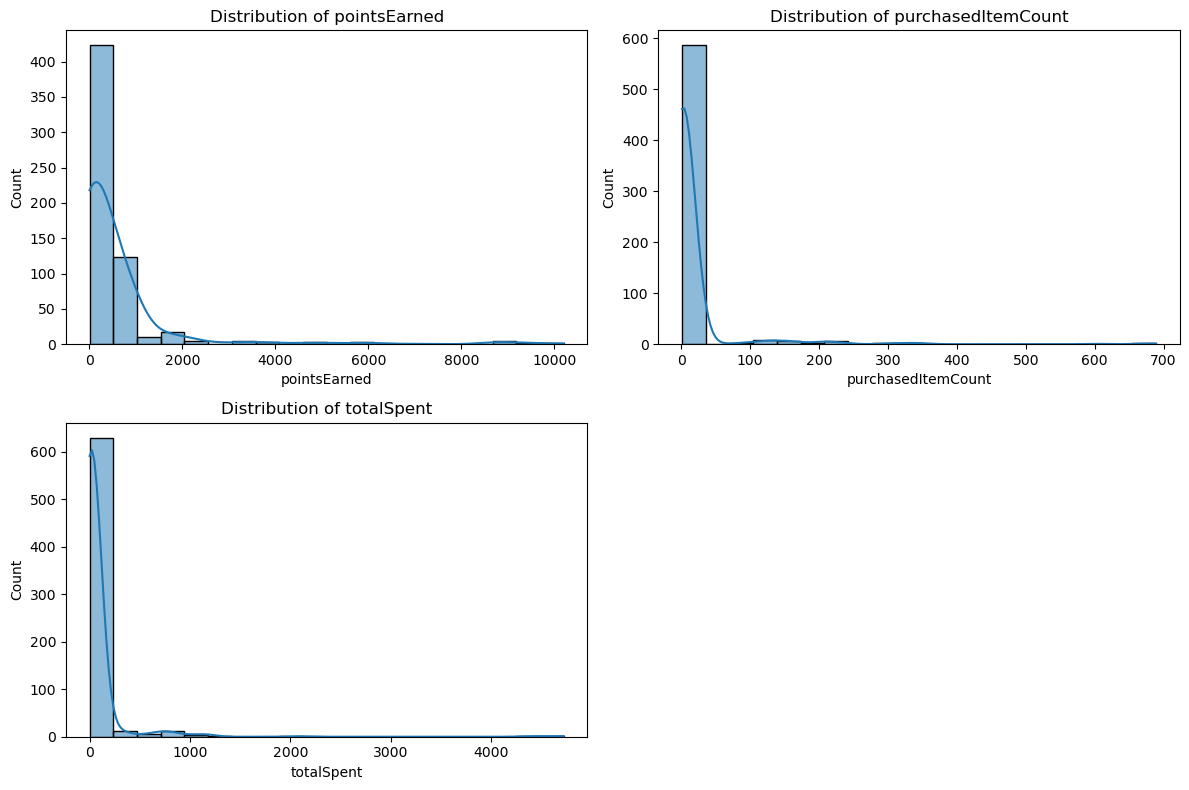

In [613]:
plot_columns_with_max_greater_than_3std(receipts_df)

### Analysis of Highly Skewed Numeric Columns  

With zero included, these columns are **highly skewed**. This means **most receipts are empty and show no actions**, which is probably expected.  

So, I **removed zeros** in my analysis. Now, the skew is **less**, but I can still see that:  
- **Points Earned**: Some receipts have **10,000+ points**.  
- **Item Count**: Some receipts contain **700+ items**.  
- **Total Spend**: Some receipts show spending of **$4,000+.**  

These extreme values might indicate:  
- A **small number of users** with very high spending. 
- Possible **data entry errors** or **special case transactions** (e.g., bulk purchases).  
- The need for **further investigation** to determine if these values are valid or anomalies.  


## check items_df

In [622]:
items_duplicates_df = check_duplicates(items_df)

No duplicates found


In [626]:
items_df.shape

(6941, 35)

In [624]:
print_null_counts(items_df)

Number of null values in each column:
receiptId: 0
barcode: 3851
brandCode: 4341
competitiveProduct: 6296
competitorRewardsGroup: 6666
deleted: 6932
description: 381
discountedItemPrice: 1172
finalPrice: 174
itemNumber: 6788
itemPrice: 174
metabriteCampaignId: 6078
needsFetchReview: 6128
needsFetchReviewReason: 6722
originalFinalPrice: 6932
originalMetaBriteBarcode: 6870
originalMetaBriteDescription: 6931
originalMetaBriteItemPrice: 6932
originalMetaBriteQuantityPurchased: 6926
originalReceiptItemText: 1181
partnerItemId: 0
pointsEarned: 6014
pointsNotAwardedReason: 6601
pointsPayerId: 5674
preventTargetGapPoints: 6583
priceAfterCoupon: 5985
quantityPurchased: 174
rewardsGroup: 5210
rewardsProductPartnerId: 4672
targetPrice: 6563
userFlaggedBarcode: 6604
userFlaggedDescription: 6736
userFlaggedNewItem: 6618
userFlaggedPrice: 6642
userFlaggedQuantity: 6642


This dataset contains a **high percentage of missing values**, with some columns missing over **95% of data**. Key observations include:  

- **Relevance Check:** Some columns (e.g., `originalMetaBriteBarcode`, `originalMetaBriteItemPrice`) might be **legacy fields** and could be dropped if they are no longer useful.   
- **Imputation Strategy:** Numeric missing fields can be filled with 0, while categorical fields can be labeled as `"Unknown"` if appropriate.  

# Question 4: Communicate with Stakeholders

# Data Quality Investigation: Findings and Questions

Hi team,

I've completed an initial analysis of our data tables and wanted to share both my findings and some critical questions that emerged during the investigation.

My Investigation Process:  
I discovered these data quality issues through exploratory analysis - examining value distributions, checking for duplicates, identifying test accounts, and analyzing NULL patterns. The duplicate records became apparent during deduplication checks, while the outliers emerged from statistical analysis.

Key Questions About the Data:  
* What's causing duplicate records in our upstream processes? I'm seeing exact duplicates in our users table that suggest a possible processing or ingestion issue. To resolve these issues, I'll need access to documentation on the upstream data collection processes to better understand how the data is being captured.
* Are the extreme values legitimate? Some receipts show 700+ items or $4,000+ in spending - I need to understand if these represent real bulk purchases or data issues. It would also be helpful to have business rules defining valid ranges for key fields like points, item counts, and spending. 
* Why do we maintain fields with >95% missing values for our reward item list? Understanding the historical context of legacy fields and their current usage will allow me to determine whether they should still be included in our analysis.
* Do we have a standardized taxonomy mapping? There are inconsistencies in how categoryCode, categoryName, and brandName align. For example, the Snacks category lacks mappings entirely, while Beverages has only a single mapped row with the rest missing. We should evaluate whether existing mappings can be leveraged to fill in these gaps where applicable.

As we scale, handling duplicates will get more complicated, and a clear criteria for distinguishing between valid transactions and test transactions would help me clean up the dataset and ensure I'm working with accurate information. Optimizing queries for historical data is also becoming trickier. So it might be worth considering a switch to NoSQL, as it could help with better scalability and performance, especially when working with large, unstructured JSON data.

I’d love to discuss these points in more detail and align on next steps. Let me know a good time to sync or if you have any initial thoughts!

Thanks,  
Yusha Wang